# Object Localisation code using FasterRCNN

In this code, detection of wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe is done. Using worldwide data, we focused on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.
The dataset can be found here.
https://www.kaggle.com/c/global-wheat-detection/data

# Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os
import ast
import matplotlib.patches as patches
from matplotlib.image import imsave
from tqdm import tqdm
from PIL import Image
import re
import keras
from torchvision import transforms
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.applications import DenseNet121

import joblib
from joblib import Parallel, delayed
import cv2
import tensorflow as tf
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations.bbox_utils import denormalize_bbox, normalize_bbox

from PIL import Image
#importing libraries for validation and training set generation
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from glob import glob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data_utils
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import time
from torch.utils.data import SubsetRandomSampler
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
import torch.nn as nn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from itertools import islice
import albumentations as alb
import sys
from keras.preprocessing.image import ImageDataGenerator
import json
import warnings
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
from pathlib import Path
#from detectron2.engine import DefaultPredictor, DefaultTrainer
from torch.utils.data.sampler import SequentialSampler
warnings.filterwarnings('ignore')
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train/86b661ae0.jpg
/kaggle/input/global-wheat-detection/train/56c1bc7f0.jpg
/kaggle/input/global-wheat-detection/train/e84d2bbd1.jpg
/kaggle/input/global-wheat-detection/train/5ea4aa57a.jpg
/kaggle/input/global-wheat-detection/train/dc8b73725.jpg
/kaggle/input/global-wheat-detection/train/e40dcc2bf.jpg
/kaggle/input/global-wheat-detection/train/c509717b1.jpg
/kaggle/input/global-wheat-detection/train/a9b3451c9.jpg
/kaggle/input/global-wheat-detection/train/38b259a9e.jpg
/kaggle/input/global-wheat-detection/train/5baa23af0.jpg
/kaggle/input/global-wheat-detection/train/c1bea7def.jpg
/kaggle/input/global-wheat-detection/train/1ee6b9669.jpg
/kaggle/input/global-wheat-detection/train/c9a573b93.jpg
/kaggle/input/global-wheat-detection/train/81eb8a758.jpg
/kaggle/input/global-wheat-detection/train/9a3fe7557.jpg
/kaggle/input/global-wheat-detection/tr

# Data Manipulation

* Setting up paths for training and test images 
* creating lists of training and testing images

In [2]:
# setting up paths for training and test images
train_dir = '../input/global-wheat-detection/train/'
test_dir = '../input/global-wheat-detection/test/'
train_csv_path = '../input/global-wheat-detection/train.csv'
image_folder_path = "/kaggle/input/global-wheat-detection/train/"
test_folder_path = "/kaggle/input/global-wheat-detection/test/"
DATA_DIR = "/kaggle/input/global-wheat-detection"

WEIGHTS_FILE = "../input/densenet169/densenet169.pth"
# printing completion of setup
print ('setup complete')

# the lists of train and test images
train_list = glob(train_dir + '*')
test_list = glob(test_dir + '*')

print('Number of train images is ',len(train_list))
print('Number of test images is ',len(test_list))

setup complete
Number of train images is  3422
Number of test images is  10


Read train data and store in dataframe

In [3]:
# read train data and store in dataframe
train_data=pd.read_csv(train_csv_path)

# printing summary of data
## train_data.describe()
train_data.head()

#read test data and store in dataframe
test_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')
test_df.shape

(10, 2)

In [4]:
# storing dataframe as train
train = train_data
train_pascal = train_data

In [5]:
#append .jpg to image ids for easier handling
train['image_id'] = train['image_id'].apply(lambda x: str(x) + '.jpg')

In [6]:
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7.jpg   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7.jpg   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7.jpg   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7.jpg   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7.jpg   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [7]:

# Let's expand the bounding box coordinates and calculate the area of all the bboxes
#i have used train in the next line as train pascal gets editted and no longer has bbox as a parameter
train_pascal[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train.bbox.tolist()], index= train_pascal.index)
train_pascal = train[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_pascal['area'] = train_pascal['width'] * train_pascal['height']
train_pascal['x_max'] = train_pascal['x_min'] + train_pascal['width']
train_pascal['y_max'] = train_pascal['y_min'] + train_pascal['height']
train_pascal = train_pascal.drop(['bbox'], axis=1)
#following parameters are recorded for all images
train_pascal = train_pascal[['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height', 'area', 'source']]

#removing these bboxes was there in a lot of notebooks
#if you wanna include them you can just comment the next line
train_pascal = train_pascal[(train_pascal['area'] < 100000) & (train_pascal['area'] > 40)]

train_pascal.head()

#this train_pascal will be saved as a new csv file.
#i didnt directly do these operations on train because it would disrupt the code you have written
#the below warning is because of that
#i will get to that later

image_id  x_min  y_min  x_max  y_max  width  height     area   source
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0   56.0    36.0   2016.0  usask_1
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0  130.0    58.0   7540.0  usask_1
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0   74.0   160.0  11840.0  usask_1
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0  109.0   107.0  11663.0  usask_1
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0  124.0   117.0  14508.0  usask_1

In [8]:
#printing total number of images in csv file by identifying unique image ids
#this also gives us the number of images without bbox
image_ids = train_pascal['image_id'].unique()
print(f'Total number of training images: {len(image_ids)}')
print(f'Images without bboxes: {len(train_list)-len(image_ids)}')

Total number of training images: 3373
Images without bboxes: 49


# Data Visualisation

In [9]:
train.head()

image_id  width  height                         bbox   source  x_min  \
0  b6ab77fd7.jpg   56.0    36.0   [834.0, 222.0, 56.0, 36.0]  usask_1  834.0   
1  b6ab77fd7.jpg  130.0    58.0  [226.0, 548.0, 130.0, 58.0]  usask_1  226.0   
2  b6ab77fd7.jpg   74.0   160.0  [377.0, 504.0, 74.0, 160.0]  usask_1  377.0   
3  b6ab77fd7.jpg  109.0   107.0  [834.0, 95.0, 109.0, 107.0]  usask_1  834.0   
4  b6ab77fd7.jpg  124.0   117.0  [26.0, 144.0, 124.0, 117.0]  usask_1   26.0   

   y_min  
0  222.0  
1  548.0  
2  504.0  
3   95.0  
4  144.0

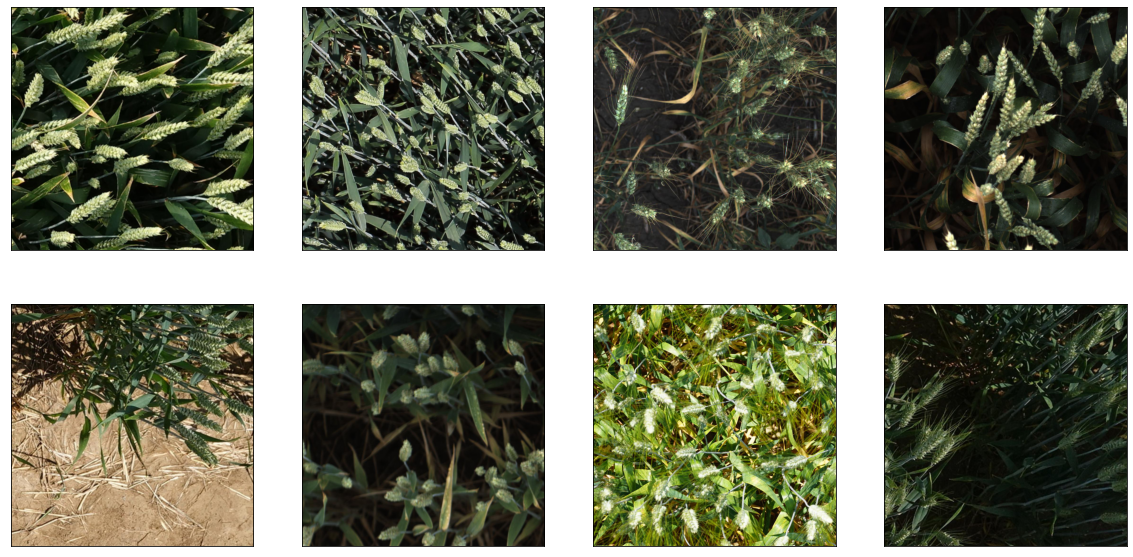

In [10]:
#displaying 8 random images from the training set

sample_indices = np.random.choice(np.unique(train["image_id"].tolist()), 8)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
count=0

for row in ax:
    for col in row:
        img = plt.imread("/kaggle/input/global-wheat-detection/train/" + sample_indices[count])
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(img)
        count = count +  1
plt.show()

In [11]:
#creating function for forming bounding boxes for all images

def get_bbox_1(image_id, df, color='white'):
    bboxes = df[df['image_id'] == image_id]
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes['x_min'].iloc[i], bboxes['y_min'].iloc[i]),
            bboxes['width'].iloc[i], 
            bboxes['height'].iloc[i], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

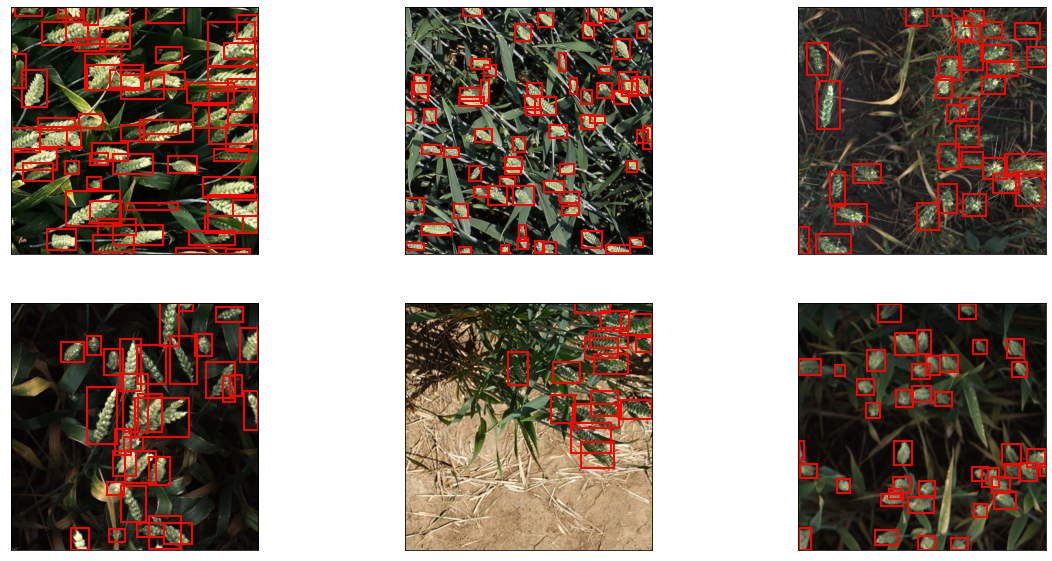

In [12]:
# displaying 6 random training images with bounding boxes

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
count=0
for row in ax:
    for col in row:
        img = plt.imread("/kaggle/input/global-wheat-detection/train/" + sample_indices[count])
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        get_bbox_1(sample_indices[count], train, color='red')
        col.imshow(img)
        count += 1
plt.show()

In [13]:
def get_bbox(bboxes, col, color='red', bbox_format='pascal_voc'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

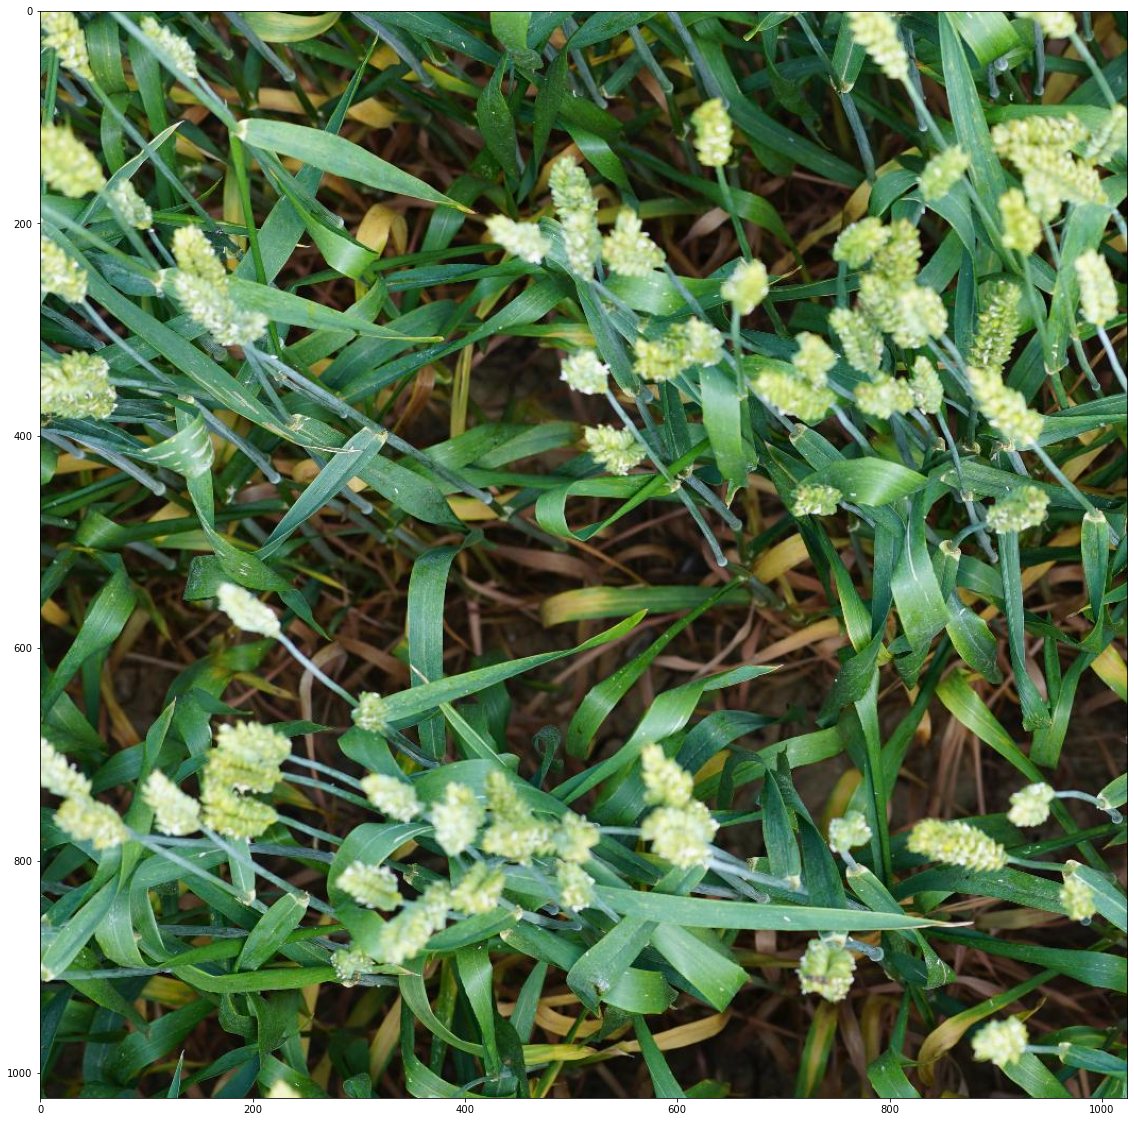

In [14]:
# Read the image on which data augmentaion is to be performed
#this is a sample image I am trying data augmentation on. if it works all we have to do is make a loop and do it for every image
image_id = 'c14c1e300'
image = cv2.imread(os.path.join(train_dir, f'{image_id}.jpg'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (20, 20))
plt.imshow(image)
plt.show()

In [15]:
#matching bbox to image

bboxes = np.stack(train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
    train[column] = bboxes[:,i]
    

In [16]:
coco_boxes = train[train['image_id'] == image_id][['x_min', 'y_min', 'width', 'height']].astype(np.int32).values
labels = np.ones((len(coco_boxes), ))

In [17]:
#Augmentation in work
aug = alb.Compose([
        alb.VerticalFlip(1),    # Verticlly flip the image
    ], bbox_params={'format': 'coco', 'label_fields': ['labels']})

In [18]:
aug_result = aug(image=image, bboxes=coco_boxes, labels=labels)

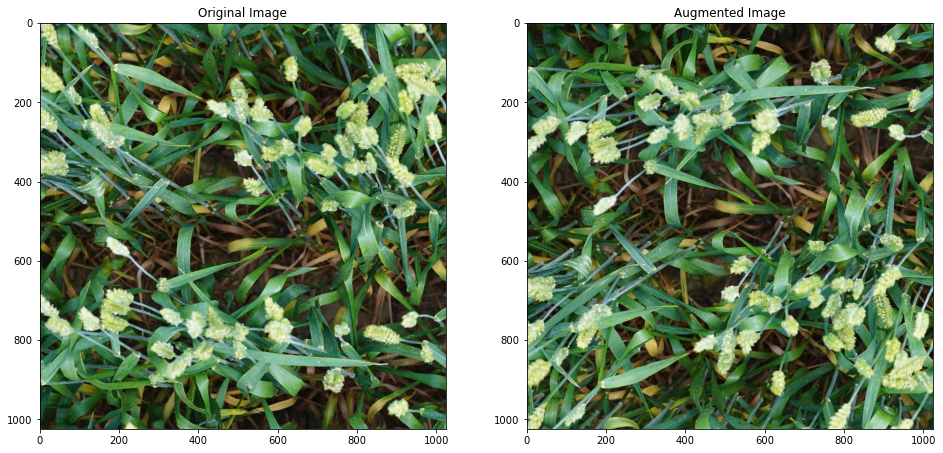

In [19]:
#have to fix this display function
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(coco_boxes, ax[0], color='red', bbox_format='coco')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red', bbox_format='coco')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])

plt.show()

# Data splitting for training and validation

In [20]:
# get a df with just image and source columns
# such that dropping duplicates will only keep unique image_ids
image_source = train_data[['image_id', 'source']].drop_duplicates()

# get lists for image_ids and sources
image_ids = image_source['image_id'].to_numpy()
sources = image_source['source'].to_numpy()



# do the split
# in other words:
# split up our data into 10 buckets making sure that each bucket
#  has a more or less even distribution of sources
# Note the use of random_state=1 to ensure the split is the same each time we run this code
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
split = skf.split(image_ids, sources) # second arguement is what we are stratifying by

# so now `split` is an iterator
# each iteration gives us a set of indices pointing to the train rows of the df 
#  (in this case 90% of all the data)
#  and a set of indices pointing to the val rows of the df
#  (in this case 10% of the data)
# we can use islice to control which split we select
select = 0
train_ix, val_ix = next(islice(split, select, select+1))

# translate indices to ids
train_ids = image_ids[train_ix]
val_ids = image_ids[val_ix]

# create corresponding dfs
print('Length of training ids', len(train_ids))
print('Length of validation ids', len(val_ids))
train_df = train_data[train_data['image_id'].isin(train_ids)]
valid_df = train_data[train_data['image_id'].isin(val_ids)]

Length of training ids 3035
Length of validation ids 338


In [21]:
train["bbox_area"]=  train_pascal['area']

* Creating a class 

In [22]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir,transform = None):
        super().__init__()
        self.df = df
        self.img_ids = df['image_id'].unique()
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx: int):
        image_id = self.img_ids[idx]
        pts = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        boxes = pts[['x_min', 'y_min', 'width', 'height']].values
        
        #convert boxes to x1,y1,x2,y2 format because that is what resnet50 faster cnn in pytorch expects
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #width times height
        area = torch.as_tensor(area, dtype = torch.float32)
        
        # there is only one class
        labels = torch.ones((pts.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((pts.shape[0],), dtype=torch.int32)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            else:
                target['boxes'] = torch.linspace(0,3, steps = 4, dtype = torch.float32)
                target['boxes'] = target['boxes'].reshape(-1,4)
            
            #target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            #target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            #target['boxes'] = torch.tensor(sample['bboxes'], dtype = torch.float32)
            
        return image, target, image_id

* The augmentations are switched off to reduce run time. An example of augmentation can be seen in data visualization section.

In [23]:
def get_training_transforms():
    return alb.Compose([
        #alb.VerticalFlip(p = 0.5),
        #alb.HorizontalFlip(p = 0.5),
        #alb.RandomBrightness(p = 0.5),
        #alb.RandomContrast(p = 0.5),
        #alb.RandomSunFlare(p=1),
        #alb.RandomFog(p=1),
        #alb.Rotate(p=1, limit=90),
        #alb.RandomSnow(p=1),
        #alb.RandomContrast(limit = 0.5,p = 1),
        #alb.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
    ToTensorV2(p = 1.0)],
    p=1.0, bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_validation_transforms():
    return alb.Compose([ToTensorV2(p = 1.0)], p = 1.0, bbox_params = alb.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_test_transforms():
    return alb.Compose([
                ToTensorV2(p=1.0)
            ])

* Submission format function

In [24]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

# Model

* Use of transfer learning is done.
* ResNet50 is used.

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,pretrained_backbone=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [26]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

* Pretrained models are alowed to be used as external data.
* Internet access is not allowed.
* Hence, loading it as external data.

In [27]:
model.load_state_dict(torch.load('../input/global-wheat-detection-public/fasterrcnn_resnet50_fpn_best.pth'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [28]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [30]:
#setting up dataloaders 
training_dataset = WheatDataset(train_df, image_folder_path, get_training_transforms())
validation_dataset = WheatDataset(valid_df, image_folder_path, get_validation_transforms())

test_dataset = WheatDataset(pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv")), os.path.join(DATA_DIR, "test"), get_test_transforms())


train_dataloader = DataLoader(
        training_dataset, batch_size=2, shuffle= True, num_workers=4,
        collate_fn= collate_fn)

valid_dataloader = DataLoader(
        validation_dataset, batch_size=2, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [31]:
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr= 0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False)

# and a learning rate scheduler
lr_scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.1, last_epoch=-1)
# let's train it for 10 epochs
num_epochs = 10

* Alter the epoch size as required.
* Running code for 10 epochs for example.

In [32]:
total_train_loss = []
total_test_loss = []
#itr = 1

for epoch in range(num_epochs):
    model.train()

    print('Epoch: ', epoch + 1)
    train_loss = []
    
    for images, targets, image_ids in tqdm(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)  
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        #if itr%50 == 0:
            #print('Iteration: ' + str(itr) + '\n' + 'Loss: '+ str(loss_value))
            
        #itr += 1
        
    epoch_loss = np.mean(train_loss)
    print('Epoch Loss is: ' , epoch_loss)
    total_train_loss.append(epoch_loss)
    
    with torch.no_grad():
        test_losses = []
        for images, targets, image_ids in tqdm(valid_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            test_loss = losses.item()
            if lr_scheduler is not None:
                lr_scheduler.step()
            test_losses.append(test_loss)
            
    test_losses_epoch = np.mean(test_losses)
    print('Test Loss: ' ,test_losses_epoch)
    total_test_loss.append(test_losses_epoch)
    
        
torch.save(model.state_dict(), 'fasterrcnn.pth')

  0%|          | 0/1518 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5852940725125814


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5782290493419184
Epoch:  2


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5650938462677052


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5803030794541512
Epoch:  3


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5647374328535065


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5769332053040611
Epoch:  4


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5649792495648694


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5816297378589416
Epoch:  5


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.565735210592175


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5767593542499655
Epoch:  6


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5639909063422947


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5762186809580707
Epoch:  7


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5634691608635333


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5792751739011008
Epoch:  8


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5648984145152239


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5771293884374686
Epoch:  9


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5643238801710376


  0%|          | 0/1518 [00:00<?, ?it/s]

Test Loss:  0.5793860942654355
Epoch:  10


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch Loss is:  0.5656259146191386


100%|██████████| 169/169 [00:26<00:00,  6.38it/s]


Test Loss:  0.5801643258368475


* Loss over epochs

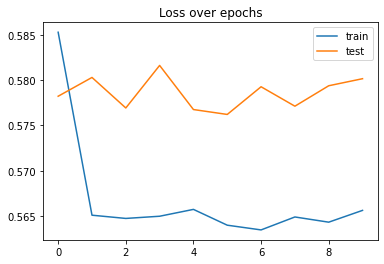

In [33]:
plt.plot(np.arange(num_epochs),total_train_loss ,label = 'train')
plt.plot(np.arange(num_epochs),total_test_loss, label = 'test')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [34]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

# Output Visulisation

In [35]:
images, targets, image_ids in next(iter(valid_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
images

prediction = model(images)

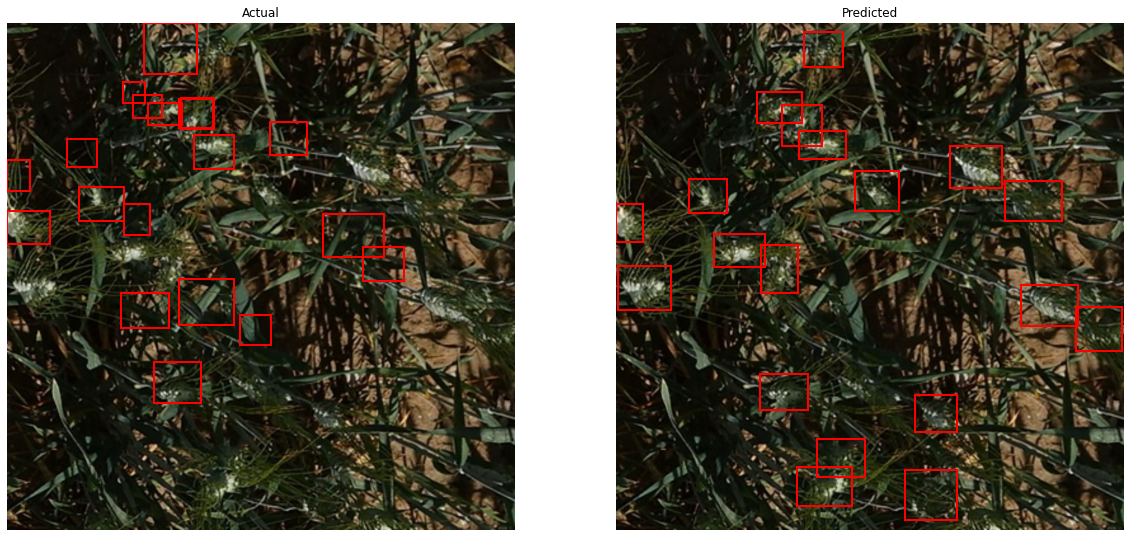

In [36]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()

for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Actual')
ax[0].set_axis_off()
ax[0].imshow(img)

thresh = 0.5
box_preds = prediction[0]['boxes'].cpu().detach().numpy()
score_preds = prediction[0]['scores'].cpu().detach().numpy()
box_preds = box_preds[score_preds >= thresh].astype(np.int32)
for box in box_preds:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Predicted')
ax[1].set_axis_off()
ax[1].imshow(img)

In [37]:
from glob import glob

# Saving Output in required format

In [38]:
origin_list = glob('../input/global-wheat-detection/test/*.jpg')
print(origin_list)

preds = []

for i, img_name in enumerate(origin_list):
    # load image
    original_img = Image.open(img_name)

    # from pil image to tensor, do not normalize image
    data_transform = transforms.Compose([transforms.ToTensor()])
    img = data_transform(original_img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)


    model.eval()
    with torch.no_grad():
        since = time.time()
        predictions = model(img.to(device))[0]
        print('{} Time:{}s'.format(i, time.time() - since))
        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()

       

        predict = ""
        for box, score in zip(predict_boxes, predict_scores):
            str_box = ""
            box[2] = box[2] - box[0]
            box[3] = box[3] - box[1]
            for b in box:
                str_box += str(b) + ' '
            predict += '1.0' + ' ' + str_box
        preds.append(predict)

name_list = [name.split('/')[-1].split('.')[0] for name in origin_list]
print(name_list)
dataframe = pd.DataFrame({"image_id": name_list, "PredictionString": preds})
dataframe.to_csv('submission.csv', index=False)

['../input/global-wheat-detection/test/cc3532ff6.jpg', '../input/global-wheat-detection/test/796707dd7.jpg', '../input/global-wheat-detection/test/53f253011.jpg', '../input/global-wheat-detection/test/51f1be19e.jpg', '../input/global-wheat-detection/test/f5a1f0358.jpg', '../input/global-wheat-detection/test/2fd875eaa.jpg', '../input/global-wheat-detection/test/51b3e36ab.jpg', '../input/global-wheat-detection/test/348a992bb.jpg', '../input/global-wheat-detection/test/cb8d261a3.jpg', '../input/global-wheat-detection/test/aac893a91.jpg']
0 Time:0.06127500534057617s
1 Time:0.06190681457519531s
2 Time:0.06218433380126953s
3 Time:0.06124281883239746s
4 Time:0.06092357635498047s
5 Time:0.06341981887817383s
6 Time:0.06056070327758789s
7 Time:0.06214737892150879s
8 Time:0.06004595756530762s
9 Time:0.060308218002319336s
['cc3532ff6', '796707dd7', '53f253011', '51f1be19e', 'f5a1f0358', '2fd875eaa', '51b3e36ab', '348a992bb', 'cb8d261a3', 'aac893a91']
